In [3]:
import cv2
import random
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from glob import glob
import re
import torch
import torch.nn as nn
import torchvision

本周作业主要更新以下内容：  
（1）图像预处理，将上面区域进行了裁剪，偏移100个像素；加入YUV直方图均衡化；  
（2）修改损失函数，增加了focal_loss损失；  
（3）加入验证模块，利用iou计算准确率；  
（4）根据交叉熵损失和focal_loss损失以及图像增强后的训练的模型进行图像展示以及准确率计算；  
（5）从sgd优化器更改为Adam，效果惊人。

数据预处理，创建自己的Dataset

In [5]:
def bright_adjust(img, a, b):
    if random.uniform(0, 1) > 0.5:
        return img
    else:
        img = img.astype(np.int)
        img = img * a + b
        return img
def crop_resize_data(img,offset=100):
    '''裁剪掉图像上面一小部分区域
    param:
    img：输入图像'''
    roi_image = img[offset:, :]
    return roi_image

class MyDataset(Dataset):
    def __init__(self,data_folder,transform=None):
        self.image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        self.label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                   for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        self.transform = transform
    def __getitem__(self,index):
        image_shape = (160,576)
        img = scipy.misc.imread(self.image_paths[index])
        roi_img = crop_resize_data(img,offset=100)
        background_color = np.array([255, 0, 0])
        image = scipy.misc.imresize(roi_img, image_shape)
        #image = scipy.misc.imresize(img, image_shape)
        #直方图均衡化
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
        image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
        contr = random.uniform(0.85, 1.15)  # Contrast augmentation
        bright = random.randint(-45, 30)  # Brightness augmentation
        image = bright_adjust(image, contr, bright)
        cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
        image = image / 255.0
        image = image.astype(np.float32)
        gt_image_file = self.label_paths[os.path.basename(self.image_paths[index])]
        gt_label = scipy.misc.imread(gt_image_file)
        roi_label = crop_resize_data(gt_label)
        gt_image = scipy.misc.imresize(roi_label, image_shape)
        #gt_image = scipy.misc.imresize(gt_label, image_shape)
        gt_background = np.all(gt_image == background_color, axis=2)
        gt_background = gt_background.reshape(*gt_background.shape, 1)  # 转为(h,w,1)
        gt_image = np.concatenate((gt_background, np.invert(gt_background)), axis=2)
        gt_image = gt_image.astype(np.float32)
        gt_image = gt_image.transpose([2,0,1])
        #print(gt_image)
        if self.transform is not None:
            image = self.transform(image)
        return image,gt_image
    def __len__(self):
        return len(self.image_paths)


Focal_loss损失函数实现：

In [6]:
# 二分类
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.75):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    def forward(self, input, target):
        pt = torch.softmax(input, dim=1)
        #选择道路预测那个输出结果
        p = pt[:, 1]
        target = target[:,1]
        #focal_loss
        loss = -self.alpha * (1 - p) ** self.gamma * target * torch.log(p) - \
             (1 - self.alpha) * p ** self.gamma * (1 - target)*torch.log(1 - p)
        #CE_loss
        #loss = -target*torch.log(p) - (1-target)*torch.log(1 - p)
        return loss.mean()

加载resnet34参数，利用双线性插值上采样，建立fcn8s

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''双线性插值'''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(np.array(weight))
def load_resnet34():
    '''从本地加载预训练的resnet34网络'''
    #自动下载
    #resnet34 = torchvision.models.resnet.resnet34(True)
    #从本地加载
    model_root = "models/resnet34-333f7ec4.pth"
    resnet34 = torchvision.models.resnet.resnet34(pretrained=False)
    pre = torch.load(model_root)
    resnet34.load_state_dict(pre)
    # print(resnet34)
    # print(list(resnet34.children())[-3])
    return resnet34
class fcn(nn.Module):
    def __init__(self,pretrained_net,num_classes):
        super(fcn,self).__init__()
        #总共利用3个特征提取层
        #第一部分，通道数128
        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4])
        # 第二部分，通道数256
        self.stage2 = list(pretrained_net.children())[-4]
        # 第三部分，通道数512
        self.stage3 = list(pretrained_net.children())[-3]

        #3个1*1卷积，将各个通道信息融合
        self.scores1 = nn.Conv2d(512,num_classes,1)
        self.scores2 = nn.Conv2d(256,num_classes,1)
        self.scores3 = nn.Conv2d(128,num_classes,1)

        #将特征图尺寸放大2倍
        self.upsample_2x = nn.ConvTranspose2d(num_classes,num_classes,kernel_size=4,stride=2,padding=1,bias=False)
        self.upsample_2x.weight.data = bilinear_kernel(num_classes,num_classes,4)
        # # 将特征图尺寸放大
        # self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        # self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4)
        #将特征尺寸放大8倍
        self.unsample_8x = nn.ConvTranspose2d(num_classes,num_classes,kernel_size=16,stride=8,padding=4,bias=False)
        self.unsample_8x.weight.data = bilinear_kernel(num_classes,num_classes,16)

    def forward(self,x):
        x = self.stage1(x)
        s1 = x
        x = self.stage2(x)
        s2 = x
        x = self.stage3(x)
        s3 = x
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2+s3
        s1 = self.scores3(s1)
        s2 = self.upsample_2x(s2)
        s = s2+s1

        s = self.unsample_8x(s)
        return s


In [8]:
import torch.optim as optim
from torchvision import transforms
from torch.nn import functional as F

训练

In [9]:

def train(epoch, net, criterion, optimizer,trainloader):
    print("epoch %d 开始训练..." % epoch)
    net.train()
    sum_loss = 0
    # 数据读取
    for i, (inputs, labels) in enumerate(trainloader):
        # 梯度清零
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        #outputs = net(inputs)
        outputs = F.sigmoid(net(inputs))
        #print(outputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        if (i + 1) % 10 == 0:
            batch_loss = sum_loss / 10
            print('epoch: %d, batch: %d loss: %.03f'
                  % (epoch, i + 1, batch_loss))
        sum_loss = 0.0

In [16]:
def Iou(inputs,targets,smooth=1):
    #把inputs和targets转成cpu再detach，这样不会占用GPU资源
    # inputs = inputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy().astype(np.int32)
    intersection = (inputs*targets).sum()

    total = (inputs + targets).sum()
    union = total - intersection
    Iou = (intersection + smooth)/(union+smooth)
    return Iou

验证模块

In [25]:
def Valid(net,testloader):
    '''加入验证模块，数据太少，仅仅选了10张图片进行计算iou'''
    net.eval()
    Iou_score = 0
    with torch.no_grad():
        for image,labels in testloader:
            outputs = net(image)
            pred = outputs.data.cpu().numpy()
            # print(pred.shape)
            pred = np.argmax(pred, axis=1)
            target = labels[:, 1]
            Iou_score += Iou(pred,target,smooth=1)
        #print("valid_acc %.03f"%(Iou_score/len(testloader)))
    return Iou_score/len(testloader)

主函数,加载之前训练好的模型，epoch=1作为演示

In [14]:
def main():
    
    epoches = 10
    batch_size = 2
    lr = 0.000001
    pretrained = True
    train_data_folder = "data/data_road/training"
    test_data_folder = "data/data_road/testing"
    save_path = "models/"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    # 读取数据
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    training_dataset = MyDataset(train_data_folder,transform)
    testing_dataset = MyDataset(test_data_folder,transform)
    trainloader = DataLoader(training_dataset, batch_size=2, shuffle=True)
    testingloader = DataLoader(testing_dataset, batch_size=2, shuffle=True)
    resnet34 = load_resnet34()
    resnet34_fcn = fcn(resnet34, 2)
    if pretrained:
        resnet34_fcn.load_state_dict(torch.load('models/resnet34_fcn_road_009.pth'))
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss()
    criterion = FocalLoss()
    optimizer = optim.SGD(resnet34_fcn.parameters(), lr=lr, momentum=0.9)
    score = 0
    temp = 0
    for epoch in range(epoches):
        train(epoch, resnet34_fcn, criterion, optimizer,trainloader)
        score = Valid(resnet34_fcn, testingloader)
        if score > temp:
            torch.save(resnet34_fcn.state_dict(), save_path + 'resnet34_fcn_road_%03d.pth' % epoch)
        temp = score
main()

epoch 0 开始训练...


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
C:\Users\Administrator\Anaconda3\lib

epoch: 0, batch: 10 loss: 0.024
epoch: 0, batch: 20 loss: 0.024
epoch: 0, batch: 30 loss: 0.023
epoch: 0, batch: 40 loss: 0.026
epoch: 0, batch: 50 loss: 0.035
epoch: 0, batch: 60 loss: 0.018
epoch: 0, batch: 70 loss: 0.023
epoch: 0, batch: 80 loss: 0.021
epoch: 0, batch: 90 loss: 0.028
epoch: 0, batch: 100 loss: 0.038
epoch: 0, batch: 110 loss: 0.022
epoch: 0, batch: 120 loss: 0.019
epoch: 0, batch: 130 loss: 0.023
epoch: 0, batch: 140 loss: 0.019


5种模型的准确率：  
（1）分别为原始交叉熵损失、focal_loss损失、图像增强后focal_loss损失、图像增强后交叉熵损失、Adam优化器

In [39]:
def valids(path):
    '''path为模型路径
    return:返回10张测试数据的iou'''
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    test_data_folder = "data/data_road/testing"
    testing_dataset = MyDataset(test_data_folder,transform)
    testingloader = DataLoader(testing_dataset, batch_size=2, shuffle=True)
    resnet34 = load_resnet34()
    resnet34_fcn = fcn(resnet34, 2)
    resnet34_fcn.load_state_dict(torch.load(path))
    score = Valid(resnet34_fcn,testingloader)
    return score
#交叉熵损失
path1 = "models/resnet34_fcn_road_ce.pth"
print("交叉熵损失：",valids(path1))
#focal_loss损失
path2 = "models/resnet34_fcn_road_focal.pth"
print("focal_loss损失：",valids(path2))
#图像增强交叉熵损失
path3 = "models/resnet34_fcn_road_enhance.pth"
print("图像增强交叉熵损失：",valids(path3))
#图像增强focal_loss
path4 = "models/resnet34_fcn_road_focal_enhance.pth"
print("图像增强focal_loss：",valids(path4))
#Adam优化器
path5 = "models/resnet34_fcn_road_Adam.pth"
print("Adam优化器：",valids(path5))

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


交叉熵损失： 0.5592067579275813
focal_loss损失： 0.3846295209349596
图像增强交叉熵损失： 0.6701320148958032
图像增强focal_loss： 0.5814714750349019
Adam优化器： 0.8616740929252911


测试

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc

def map_sequence(mask,image):
    # 将网络输出的结果映射的到图像上
    image = scipy.misc.imresize(image,(160,576))
    _,dst_row, dst_col = mask.shape
    dst = np.zeros((dst_row, dst_col, 3), dtype=np.uint8)  # 输出图片，注意数据类型
    for j in range(dst_row - 1):
        for k in range(dst_col - 1):
            if mask[0,j, k] == 1:
                image[j, k] = (255,0,0)
            else:
                image[j, k] = image[j,k]
    image.transpose([0,2,1])
    return image
def predict(input_image,model,index):
    preprocess = transforms.Compose([
        transforms.Resize((160,576)),
        transforms.ToTensor()])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = model(input_batch)
    #print(output.shape)
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    dst = map_sequence(pred,input_image)
    plt.subplot(1,3,index)
    plt.imshow(dst)
    plt.show()
# img_path = "um_000031.png"
# input_image = Image.open(img_path)
# predict(input_image,model)
# path = "./test"
# index = 1
# for item in os.listdir(path):
#     img_path = os.path.join(path,item)
#     input_image = Image.open(img_path)
#     predict(input_image,model,index)
#     index+=1

5种模型分别测试：

In [33]:
def show(path):
    resnet34 = load_resnet34()
    model = fcn(resnet34,2)
    model.load_state_dict(torch.load(path))
    model.eval()
    path = "./test"
    index = 1
    for item in os.listdir(path):
        img_path = os.path.join(path,item)
        input_image = Image.open(img_path)
        predict(input_image,model,index)
        index+=1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  import sys


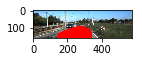

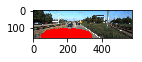

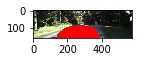

In [34]:
path1 = "models/resnet34_fcn_road_ce.pth"
show(path1)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  import sys


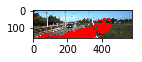

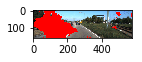

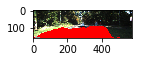

In [35]:
path2 = "models/resnet34_fcn_road_focal.pth"
show(path2)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  import sys


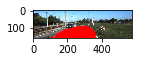

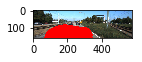

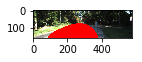

In [36]:
path3 = "models/resnet34_fcn_road_enhance.pth"
show(path3)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  import sys


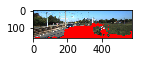

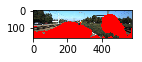

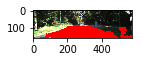

In [37]:
path4 = "models/resnet34_fcn_road_focal_enhance.pth"
show(path4)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  import sys


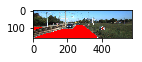

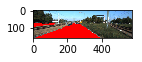

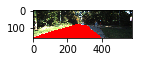

In [40]:
path5 = "models/resnet34_fcn_road_Adam.pth"
show(path5)

总结  
（1）发现图像增强后二分类交叉熵损失训练的结果准确率还不错，效果也可以；  
（2）focal_loss作为损失函数，因为数据量太小，很难收敛；  
（3）之前用的sgd优化器收敛效果不好，改用Adam，loss下降很快，准确率之间达到0.85以上，效果最好